In [1]:
import os
import pandas as pd
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import hflip, resize, crop
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

In [2]:
root = '/kaggle/input/cityscapes-pix2pix-dataset'
df = pd.read_csv(f'{root}/metadata.csv')
train_df = df.query("split == 'train'").reset_index(drop=True)
val_df = df.query("split == 'val'").reset_index(drop=True)
train_df.head()

,image_id,split,image_path
0,1,train,train/1.jpg
1,10,train,train/10.jpg
2,100,train,train/100.jpg
3,1000,train,train/1000.jpg
4,1001,train,train/1001.jpg


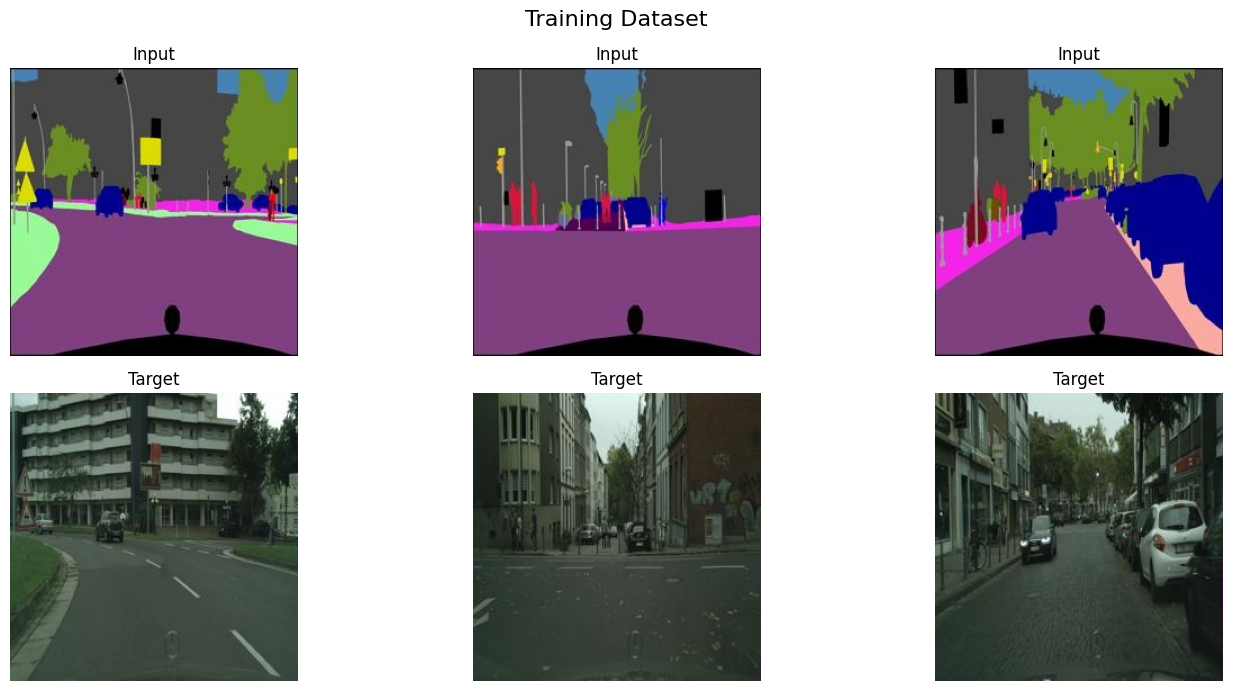

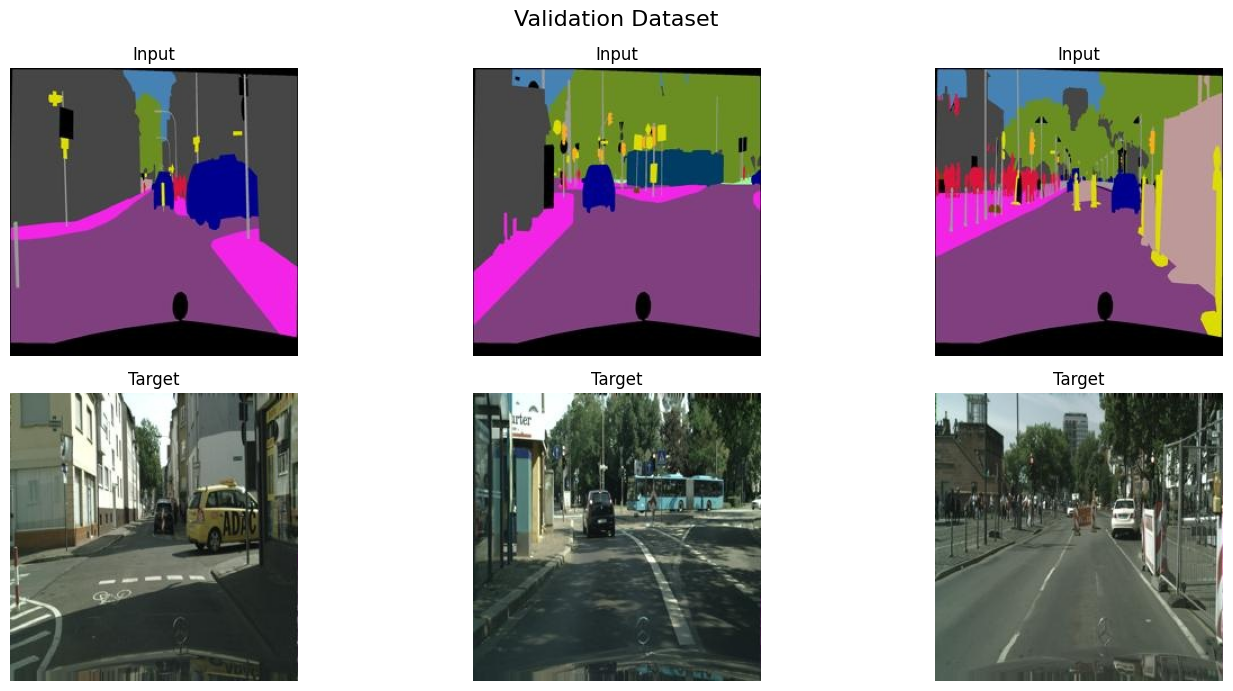

In [3]:
# Function to split images into input and target
def split_image(image_path):
    img = Image.open(image_path)
    width, height = img.size
    target_img = img.crop((0, 0, width // 2, height))  # Left half
    input_img = img.crop((width // 2, 0, width, height))  # Right half
    return input_img, target_img

# Function to prepare and visualize images for Pix2Pix
def visualize_pix2pix_data(df, root_dir, title, num_images=3):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 7))
    for i in range(num_images):
        img_path = os.path.join(root_dir, df['image_path'].iloc[i])
        input_img, target_img = split_image(img_path)
        
        # Plot input image
        axes[0, i].imshow(input_img)
        axes[0, i].axis("off")
        axes[0, i].set_title("Input")

        # Plot target image
        axes[1, i].imshow(target_img)
        axes[1, i].axis("off")
        axes[1, i].set_title("Target")
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize 3 samples from the training dataset
visualize_pix2pix_data(train_df, root, "Training Dataset")

# Visualize 3 samples from the validation dataset
visualize_pix2pix_data(val_df, root, "Validation Dataset")

In [4]:
# Dataset Class with Random Jitter and Mirroring
class Pix2PixDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, augmentation=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths and metadata.
            root_dir (str): Root directory containing the images.
            transform (callable, optional): Transform to apply to the images.
            augmentation (callable, optional): Augmentations to apply to paired images.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the full path to the image
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx]['image_path'])
        img = Image.open(img_path)

        # Split image into input and target
        width, height = img.size
        target_img = img.crop((0, 0, width // 2, height))  # Left half
        input_img = img.crop((width // 2, 0, width, height))  # Right half

        # Apply augmentations (if specified)
        if self.augmentation:
            input_img, target_img = self.augmentation(input_img, target_img)

        # Apply transformations (e.g., resizing, normalization)
        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img


# Augmentation with Random Jitter and Mirroring
class RandomJitterAndMirror:
    def __init__(self, resize_size=(286, 286), crop_size=(256, 256), flip_prob=0.5):
        """
        Args:
            resize_size: Size for resizing during jittering.
            crop_size: Size for cropping.
            flip_prob: Probability of horizontal flip.
        """
        self.resize_size = resize_size
        self.crop_size = crop_size
        self.flip_prob = flip_prob

    def __call__(self, input_img, target_img):
        # Resize both images to a slightly larger size (random jitter)
        input_img = resize(input_img, self.resize_size)
        target_img = resize(target_img, self.resize_size)

        # Random crop to the final size
        i, j, h, w = transforms.RandomCrop.get_params(input_img, output_size=self.crop_size)
        input_img = crop(input_img, i, j, h, w)
        target_img = crop(target_img, i, j, h, w)

        # Random horizontal flip
        if random.random() < self.flip_prob:
            input_img = hflip(input_img)
            target_img = hflip(target_img)

        return input_img, target_img


# Define augmentation for training
augmentation = RandomJitterAndMirror(resize_size=(286, 286), crop_size=(256, 256), flip_prob=0.5)

# Define image transformations (resize, normalization)
transform = transforms.Compose([
    transforms.ToTensor(),         # Convert PIL image to Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Create datasets for training and validation
train_dataset = Pix2PixDataset(train_df, root, transform=transform, augmentation=augmentation)
val_dataset = Pix2PixDataset(val_df, root, transform=transform)  # No augmentation for validation
print(len(train_dataset))
# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Check dataset shape (Optional Debugging Step)
input_img, target_img = next(iter(train_loader))
print(f"Input shape: {input_img.shape}, Target shape: {target_img.shape}")

2975
Input shape: torch.Size([16, 3, 256, 256]), Target shape: torch.Size([16, 3, 256, 256])


In [5]:
class ConvBlock(nn.Module):
    """
    A generalized convolutional block that supports both Conv2D and ConvTranspose2D.
    Args:
        in_channels: Number of input channels.
        out_channels: Number of output channels.
        kernel_size: Size of the convolution kernel (default: 4).
        stride: Stride of the convolution (default: 2).
        padding: Padding for the convolution (default: 1).
        transposed: Whether to use ConvTranspose2D instead of Conv2D (default: False).
        norm: Whether to apply BatchNorm (default: True).
        activation: Activation function to use (default: LeakyReLU for Conv2D, ReLU for ConvTranspose2D).
        dropout: Whether to apply Dropout (default: False).
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 transposed=False, norm=True, activation=None, dropout=False):
        super(ConvBlock, self).__init__()
        # Choose between Conv2D and ConvTranspose2D
        if transposed:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

        # Apply BatchNorm if required
        self.norm = nn.BatchNorm2d(out_channels) if norm else nn.Identity()

        # Set default activation if none is provided
        if activation is None:
            activation = nn.ReLU() if transposed else nn.LeakyReLU(0.2)
        self.activation = activation

        # Apply Dropout if required
        self.dropout = nn.Dropout(0.5) if dropout else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return self.dropout(x)

In [6]:
class Downsample(nn.Module):
    """
    A downsampling block with Conv2D -> BatchNorm (optional) -> LeakyReLU.
    """
    def __init__(self, in_channels, out_channels, apply_norm=True):
        super(Downsample, self).__init__()
        self.block = ConvBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=4,
            stride=2,
            padding=1,
            transposed=False,
            norm=apply_norm,
            activation=nn.LeakyReLU(0.2),
            dropout=False
        )

    def forward(self, x):
        return self.block(x)

In [7]:
class Upsample(nn.Module):
    """
    An upsampling block with ConvTranspose2D -> BatchNorm -> ReLU -> Dropout (optional).
    """
    def __init__(self, in_channels, out_channels, apply_dropout=False):
        super(Upsample, self).__init__()
        self.block = ConvBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=4,
            stride=2,
            padding=1,
            transposed=True,
            norm=True,
            activation=nn.ReLU(),
            dropout=apply_dropout
        )

    def forward(self, x):
        return self.block(x)

In [8]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetGenerator, self).__init__()

        self.down1 = Downsample(in_channels, 64, apply_norm=False)
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128, 256)
        self.down4 = Downsample(256, 512)
        self.down5 = Downsample(512, 512)
        self.down6 = Downsample(512, 512)
        self.down7 = Downsample(512, 512)
        self.down8 = Downsample(512, 512)

        self.up1 = Upsample(512, 512, apply_dropout=True)
        self.up2 = Upsample(1024, 512, apply_dropout=True)  # Concatenation with d7
        self.up3 = Upsample(1024, 512, apply_dropout=True)  # Concatenation with d6
        self.up4 = Upsample(1024, 512)  # Concatenation with d5
        self.up5 = Upsample(1024, 256)  # Concatenation with d4
        self.up6 = Upsample(512, 128)  # Concatenation with d3
        self.up7 = Upsample(256, 64)  # Concatenation with d2
        self.final = nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], dim=1))
        u3 = self.up3(torch.cat([u2, d6], dim=1))
        u4 = self.up4(torch.cat([u3, d5], dim=1))
        u5 = self.up5(torch.cat([u4, d4], dim=1))
        u6 = self.up6(torch.cat([u5, d3], dim=1))
        u7 = self.up7(torch.cat([u6, d2], dim=1))
        u8 = self.final(torch.cat([u7, d1], dim=1))
        return torch.tanh(u8)

In [9]:
class PatchDiscriminator(nn.Module):
    """
    A PatchGAN discriminator for distinguishing real vs fake patches.
    """
    def __init__(self, in_channels):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(in_channels * 2, 64, stride=2, transposed=False, norm=False, activation=nn.LeakyReLU(0.2)),
            ConvBlock(64, 128, stride=2, transposed=False, norm=True, activation=nn.LeakyReLU(0.2)),
            ConvBlock(128, 256, stride=2, transposed=False, norm=True, activation=nn.LeakyReLU(0.2)),
            ConvBlock(256, 512, stride=1, transposed=False, norm=True, activation=nn.LeakyReLU(0.2)),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),  # Final output layer
            nn.Sigmoid()  # Output probability
        )

    def forward(self, input_img, target_img):
        combined = torch.cat([input_img, target_img], dim=1)
        return self.model(combined)

In [10]:
# Adversarial loss
adversarial_loss = nn.BCEWithLogitsLoss()

# L1 loss for pixel-wise reconstruction
reconstruction_loss = nn.L1Loss()

In [11]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# Initialize models
generator = UNetGenerator(in_channels=3, out_channels=3).to(device)
discriminator = PatchDiscriminator(in_channels=3).to(device)

# Optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [15]:
# Training Loop
num_epochs = 100
generator_losses, discriminator_losses = [], []  # To track generator and discriminator losses
recon_weight = 100
val_iter = iter(val_loader)
for epoch in range(num_epochs):
    generator_epoch_loss, discriminator_epoch_loss = 0.0, 0.0

    # Training Loop with tqdm progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    for i, (input_images, target_images) in enumerate(train_loader_tqdm):
        input_images, target_images = input_images.to(device), target_images.to(device)

        generator.train()  
        discriminator.train()
        # Train Discriminator
        discriminator_optimizer.zero_grad()
        real_preds = discriminator(input_images, target_images)
        fake_images = generator(input_images)
        fake_preds = discriminator(input_images, fake_images.detach())
        disc_loss = adversarial_loss(real_preds, torch.ones_like(real_preds)) + \
                    adversarial_loss(fake_preds, torch.zeros_like(fake_preds))
        disc_loss.backward()
        discriminator_optimizer.step()

        # Train Generator
        generator_optimizer.zero_grad()
        fake_preds = discriminator(input_images, fake_images)
        adv_loss = adversarial_loss(fake_preds, torch.ones_like(fake_preds))
        recon_loss = reconstruction_loss(fake_images, target_images) * recon_weight  # L1 loss weighted
        gen_loss = adv_loss + recon_loss
        gen_loss.backward()
        generator_optimizer.step()

        # Track losses
        generator_epoch_loss += gen_loss.item()
        discriminator_epoch_loss += disc_loss.item()

        # Update tqdm with losses
        train_loader_tqdm.set_postfix({
            "Gen Loss": gen_loss.item(),
            "Disc Loss": disc_loss.item()
        })

    # Average losses for the epoch
    generator_epoch_loss /= len(train_loader)
    discriminator_epoch_loss /= len(train_loader)
    generator_losses.append(generator_epoch_loss)
    discriminator_losses.append(discriminator_epoch_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"Generator Loss: {generator_epoch_loss:.4f}, Discriminator Loss: {discriminator_epoch_loss:.4f}")

    # Plot input, target, and generated images every 3 epochs
    if (epoch + 1) % 5 == 0:
        generator.eval()  # Set generator to evaluation mode
        with torch.no_grad():
            input_images, target_images = next(val_iter)
            input_images, target_images = input_images.to(device), target_images.to(device)
            generated_images = generator(input_images)

            # Plot the images
            num_images = 3
            fig, axes = plt.subplots(num_images, 3, figsize=(15, 10))
            for i in range(num_images):
                # Input image
                axes[i, 0].imshow(input_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
                axes[i, 0].set_title("Input")
                axes[i, 0].axis("off")

                # Target image
                axes[i, 1].imshow(target_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
                axes[i, 1].set_title("Target")
                axes[i, 1].axis("off")

                # Generated image
                axes[i, 2].imshow(generated_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
                axes[i, 2].set_title("Generated")
                axes[i, 2].axis("off")

            plt.tight_layout()
            plt.show()



Epoch 1/2: 100%|██████████| 186/186 [01:58<00:00,  1.57it/s, Gen Loss=23.9, Disc Loss=1.03]


Epoch [1/2] Generator Loss: 19.8152, Discriminator Loss: 1.0678


Epoch 2/2: 100%|██████████| 186/186 [01:58<00:00,  1.57it/s, Gen Loss=18.3, Disc Loss=1.03]

Epoch [2/2] Generator Loss: 19.4992, Discriminator Loss: 1.0513


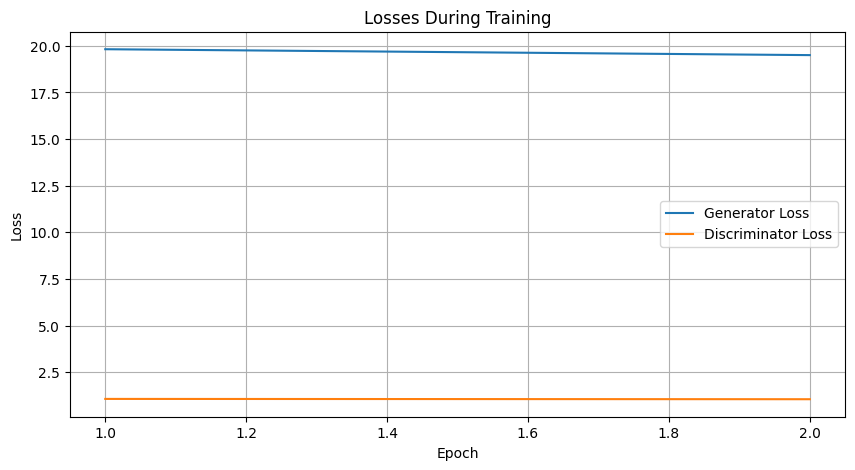

In [16]:
# Plot generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), generator_losses, label="Generator Loss")
plt.plot(range(1, num_epochs + 1), discriminator_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses During Training")
plt.legend()
plt.grid(True)
plt.show()